This notebook work on using Voting ensemble technique to classify disaster tweets from non disaster tweets

The Classification steps:
* Preprocessing
    * remove urls, stopwords, punctuations, and small words
    * translate emojis   
* Feature Extraction and Analysis
    * use unigram to explore frequent words on each class
    * use word cloud as explanatory analysis for unigram output
    * use bigram to explore frequent bigrams on each class
    * use bar graph to visualize bigram results
    * apply unigram analysis on both location and keyword columns
    * use bar graph to visualize unigram of location and keyword columns
    * format feature vector for both training and testing data
* Model Implementation
    * use Naive Bayes, Suppprt vector machine, K nearest neighbor, and logistic regression algorithms
    * split training data (0.33 for testing) and test it on each algorithm 
    * apply cross validation on each algorithm
    * use class report to evaluate each run
    * apply voting ensemble technique on the four algorithms
    * apply test feature vectors for each algorthim separately then on voting ensemble technique

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
#load necessary libraries
import nltk
from nltk.corpus import stopwords
import re, string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from emoji import UNICODE_EMOJI
import emoji
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [3]:
#load train and test data to dataframes
train_df=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv',encoding="utf-8")
test_df=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv',encoding="utf-8")
#visulaize first top 10 columns of train data
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [4]:
#visulaize first top 10 columns of test data
test_df.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


# Preprocessing

In [5]:
#preprocessing train data
#extract hashtags
train_df["hashtags"]=train_df["text"].apply(lambda x:re.findall(r"#(\w+)",x.lower()))
test_df["hashtags"]=test_df["text"].apply(lambda x:re.findall(r"#(\w+)",x.lower()))

#translate emojis to text
train_df["clean_text"]=train_df["text"].apply(lambda x: emoji.demojize(x))
test_df["clean_text"]=test_df["text"].apply(lambda x: emoji.demojize(x))

#remove urls
train_df["clean_text"]=train_df["clean_text"].apply(lambda x: re.sub(r"http:\S+",'',x))
train_df["clean_text"]=train_df["clean_text"].apply(lambda x: re.sub(r"https:\S+",'',x))
test_df["clean_text"]=test_df["clean_text"].apply(lambda x: re.sub(r"http:\S+",'',x))
test_df["clean_text"]=test_df["clean_text"].apply(lambda x: re.sub(r"https:\S+",'',x))

#tokenize tweets
train_df["clean_text"]=train_df["clean_text"].apply(lambda x: nltk.word_tokenize(x.strip().lower()))
test_df["clean_text"]=test_df["clean_text"].apply(lambda x: nltk.word_tokenize(x.strip().lower()))

#remove punctuations from tweets
train_df["clean_text"]=train_df["clean_text"].apply(lambda x: [re.sub(r'['+string.punctuation+']','',y.strip()) for y in x])
test_df["clean_text"]=test_df["clean_text"].apply(lambda x: [re.sub(r'['+string.punctuation+']','',y.strip()) for y in x])

#load stopwords set
stopwrds = set(stopwords.words('english'))
#remove stop words from tweets
train_df["clean_text"]=train_df["clean_text"].apply(lambda x: [y for y in x if (y.strip() not in stopwrds)])
test_df["clean_text"]=test_df["clean_text"].apply(lambda x: [y for y in x if (y.strip() not in stopwrds)])

#remove new lines in tweets
train_df["clean_text"]=train_df["clean_text"].apply(lambda x: [re.sub('\\n','',y.strip()) for y in x])
test_df["clean_text"]=test_df["clean_text"].apply(lambda x: [re.sub('\\n','',y.strip()) for y in x])

#remove spaces and small words from tweets
train_df["clean_text"]=train_df["clean_text"].apply(lambda x: [y.strip() for y in x if (y.strip() != "") and len(y.strip())>2])
test_df["clean_text"]=test_df["clean_text"].apply(lambda x: [y.strip() for y in x if (y.strip() != "") and len(y.strip())>2])

#convert tokens of tweets to text
train_df["clean_text"]=train_df["clean_text"].apply(lambda x: ' '.join(x))
test_df["clean_text"]=test_df["clean_text"].apply(lambda x: ' '.join(x))

#convert tokens hashtags to text
train_df["hashtags"]=train_df["hashtags"].apply(lambda x: ' '.join(x))
test_df["hashtags"]=test_df["hashtags"].apply(lambda x: ' '.join(x))

#convert lower cases of keyword and location
train_df["keyword"]=train_df["keyword"].apply(lambda x: x if str(x).lower() == "nan" else x.lower())
train_df["location"]=train_df["location"].apply(lambda x: x if str(x).lower() == "nan" else x.lower())
test_df["keyword"]=test_df["keyword"].apply(lambda x: x if str(x).lower() == "nan" else x.lower())
test_df["location"]=test_df["location"].apply(lambda x: x if str(x).lower() == "nan" else x.lower())

#visualize data 
train_df.head(10)

,id,keyword,location,text,target,hashtags,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,earthquake,deeds reason earthquake may allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,forest fire near ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,wildfires,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,alaska wildfires,got sent photo ruby alaska smoke wildfires pou...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,rockyfire cafire wildfires,rockyfire update california hwy closed directi...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,flood disaster,flood disaster heavy rain causes flash floodin...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,,top hill see fire woods
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,,emergency evacuation happening building across...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,,afraid tornado coming area


In [6]:
test_df.head(10)

,id,keyword,location,text,hashtags,clean_text
0,0,NaN,NaN,Just happened a terrible car crash,,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",earthquake,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,spokane wildfires,apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,,typhoon soudelor kills china taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake,,shaking earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...,,probably still show life arsenal yesterday
7,22,NaN,NaN,Hey! How are you?,,hey
8,27,NaN,NaN,What a nice hat?,,nice hat
9,29,NaN,NaN,Fuck off!,,fuck


# Analysis 

**Data Statistics**

In [7]:
#total data length
print("length of train data",len(train_df))
print("length of test data",len(test_df))

# unique location and keyword size of data
print("Checking train location column values",len(train_df.location.unique()))
print("Checking train keyword column values",len(train_df.keyword.unique()))
print("Checking test location column values",len(test_df.location.unique()))
print("Checking test keyword column values",len(test_df.keyword.unique()))

#number of disaster tweets
print("disaster tweets", len(train_df[train_df["target"]==1]) )
print("non-disaster tweets", len(train_df[train_df["target"]==0]) )

length of train data 7613
length of test data 3263
Checking train location column values 3234
Checking train keyword column values 222
Checking test location column values 1560
Checking test keyword column values 222
disaster tweets 3271
non-disaster tweets 4342


**Graphical analysis**

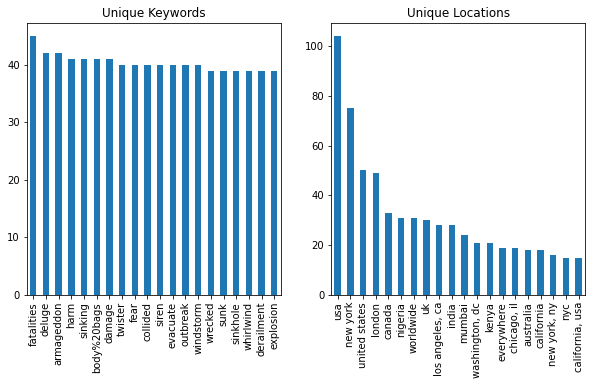

In [8]:
plt.subplots(1,2,figsize=(10,5))
#visualize top 20 train unique keywords
plt.subplot(1,2,1)
train_df.keyword.value_counts()[:20].plot(kind="bar",title="Unique Keywords")

#visualize top 20 train unique locations
plt.subplot(1,2,2)
train_df.location.value_counts()[:20].plot(kind="bar",title="Unique Locations")

plt.show()

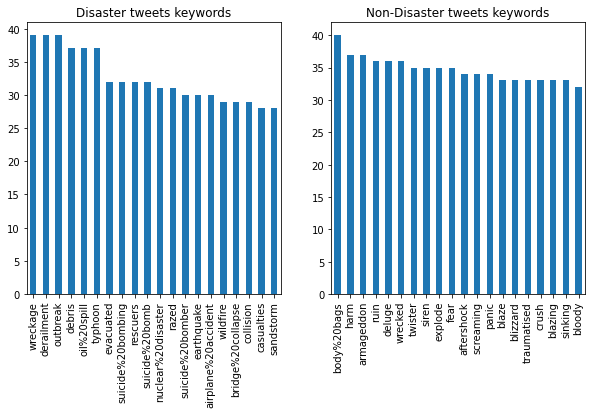

In [9]:
plt.subplots(1,2,figsize=(10,5))
#visualize top 20 disaster tweets and their keywords bar graph
plt.subplot(1,2,1)
train_df[train_df["target"]==1].keyword.value_counts()[:20].plot(kind="bar",title="Disaster tweets keywords")

#visualize top 20 non disaster tweets and their keywords bar graph
plt.subplot(1,2,2)
train_df[train_df["target"]==0].keyword.value_counts()[:20].plot(kind="bar",title="Non-Disaster tweets keywords")

plt.show()

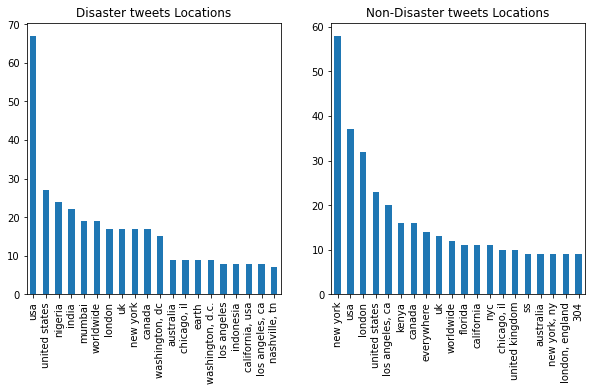

In [10]:
plt.subplots(1,2,figsize=(10,5))
#visualize top 20 disaster tweets and their locations bar graph
plt.subplot(1,2,1)
train_df[train_df["target"]==1].location.value_counts()[:20].plot(kind="bar",title="Disaster tweets Locations")

#visualize top 20 non disaster tweets and their locations bar graph
plt.subplot(1,2,2)
train_df[train_df["target"]==0].location.value_counts()[:20].plot(kind="bar",title="Non-Disaster tweets Locations")

plt.show()

# Feature Extraction

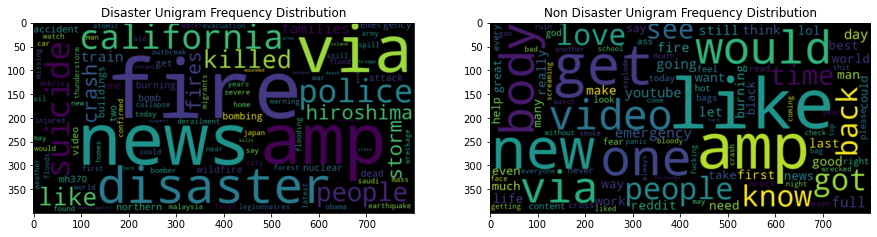

In [11]:
plt.subplots(1,2,figsize=(15,15))
plt.subplot(1,2,1)
#Uigram Frequency distribution for disaster tweets
#convert disaster tweets into single string
txt=' '.join(train_df[train_df["target"]==1]["clean_text"])
disaster_unigram=nltk.FreqDist(nltk.word_tokenize(txt))

#visualize unigram frequency distribution for disaster tweets using wordcloud
disaster_wc = WordCloud(width=800, height=400, max_words=100).generate_from_frequencies(disaster_unigram)
plt.title("Disaster Unigram Frequency Distribution")
plt.imshow(disaster_wc, interpolation="bilinear")

plt.subplot(1,2,2)
#Uigram Frequency distribution for non disaster tweets
#convert non disaster tweets into single string
txt=' '.join(train_df[train_df["target"]==0]["clean_text"])
nondisaster_unigram=nltk.FreqDist(nltk.word_tokenize(txt))

#visualize unigram frequency distribution for non disaster tweets using wordcloud
nondisaster_wc = WordCloud(width=800, height=400, max_words=100).generate_from_frequencies(nondisaster_unigram)
plt.title("Non Disaster Unigram Frequency Distribution")
plt.imshow(nondisaster_wc, interpolation="bilinear")

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


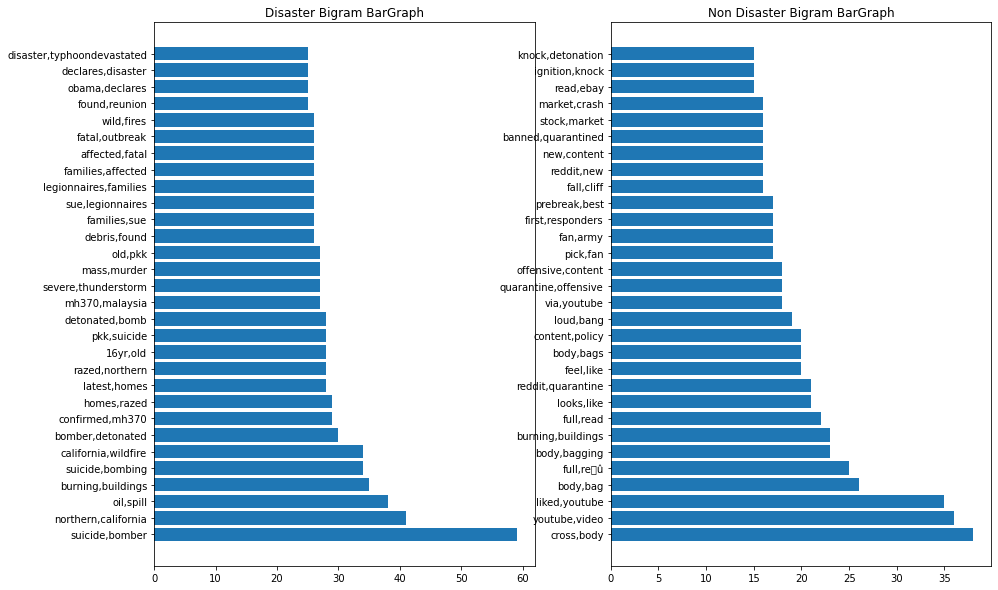

In [12]:
plt.subplots(1,2,figsize=(15,10))

plt.subplot(1,2,1)
#Bigram Frequency distribution for disaster tweets
#convert disaster tweets into single string
txt=' '.join(train_df[train_df["target"]==1]["clean_text"])
disaster_bigram=nltk.FreqDist(nltk.bigrams(nltk.word_tokenize(txt)))
tmplst=disaster_bigram.most_common(30)

#visualize Bigram frequency distribution for disaster tweets using bar graph
wrd,cnt=zip(*tmplst)
wrd=[ x+","+y for (x,y) in wrd]
plt.barh(wrd,cnt)
plt.title("Disaster Bigram BarGraph")

plt.subplot(1,2,2)
#Bigram Frequency distribution for non disaster tweets
#convert non disaster tweets into single string
txt=' '.join(train_df[train_df["target"]==0]["clean_text"])
nondisaster_bigram=nltk.FreqDist(nltk.bigrams(nltk.word_tokenize(txt)))
tmplst=nondisaster_bigram.most_common(30)

#visualize Bigram frequency distribution for non disaster tweets using bar graph
wrd,cnt=zip(*tmplst)
wrd=[ x+","+y for (x,y) in wrd]
plt.barh(wrd,cnt)
plt.title("Non Disaster Bigram BarGraph")
plt.show()


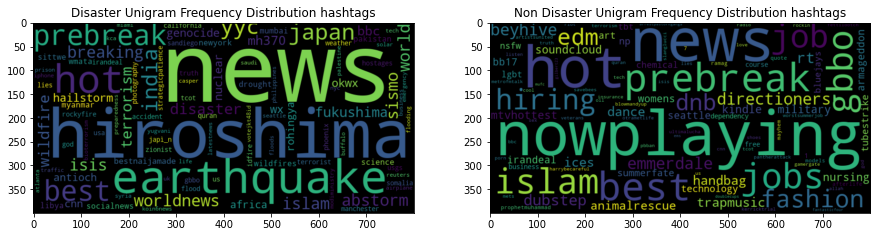

In [13]:
plt.subplots(1,2,figsize=(15,15))
plt.subplot(1,2,1)
#Uigram Frequency distribution for disaster hashtags
#convert disaster hashtags into single string
txt=' '.join(train_df[train_df["target"]==1]["hashtags"])
disaster_unigram_hash=nltk.FreqDist(nltk.word_tokenize(txt))

#visualize unigram frequency distribution for disaster hashtags using wordcloud
disaster_wc = WordCloud(width=800, height=400, max_words=100).generate_from_frequencies(disaster_unigram_hash)
plt.title("Disaster Unigram Frequency Distribution hashtags")
plt.imshow(disaster_wc, interpolation="bilinear")

plt.subplot(1,2,2)
#Uigram Frequency distribution for non disaster hashtags
#convert non disaster hashtags into single string
txt=' '.join(train_df[train_df["target"]==0]["hashtags"])
nondisaster_unigram_hash=nltk.FreqDist(nltk.word_tokenize(txt))

#visualize unigram frequency distribution for non disaster hashtags using wordcloud
nondisaster_wc = WordCloud(width=800, height=400, max_words=100).generate_from_frequencies(nondisaster_unigram_hash)
plt.title("Non Disaster Unigram Frequency Distribution hashtags")
plt.imshow(nondisaster_wc, interpolation="bilinear")

**Convert Tweet to train feature vector**

In [14]:
#compute unigram feature vector for tweet likelihood to disaster
train_df["unigram_disas"]=train_df["clean_text"].apply(lambda x: sum([disaster_unigram.get(wrd) for wrd in nltk.word_tokenize(x) if disaster_unigram.get(wrd)!=None])/len(disaster_unigram))

#compute unigram feature vector for tweet likelihood to non disaster
train_df["unigram_nondisas"]=train_df["clean_text"].apply(lambda x: sum([nondisaster_unigram.get(wrd) for wrd in nltk.word_tokenize(x) if nondisaster_unigram.get(wrd)!=None])/len(nondisaster_unigram))

#compute unigram feature vector for hashtags likelihood to disaster
train_df["unigram_disas_hash"]=train_df["hashtags"].apply(lambda x: sum([disaster_unigram_hash.get(wrd) for wrd in nltk.word_tokenize(x) if disaster_unigram_hash.get(wrd)!=None])/len(disaster_unigram_hash))

#compute unigram feature vector for hashtags likelihood to non disaster
train_df["unigram_nondisas_hash"]=train_df["hashtags"].apply(lambda x: sum([nondisaster_unigram_hash.get(wrd) for wrd in nltk.word_tokenize(x) if nondisaster_unigram_hash.get(wrd)!=None])/len(nondisaster_unigram_hash))

#compute bigram feature vector for tweet likelihood to disaster
train_df["bigram_disas"]=train_df["clean_text"].apply(lambda x: sum([disaster_bigram.get(wrd) for wrd in nltk.bigrams(nltk.word_tokenize(x)) if disaster_bigram.get(wrd)!=None])/len(disaster_bigram))

#compute bigram feature vector for tweet likelihood to non disaster
train_df["bigram_nondisas"]=train_df["clean_text"].apply(lambda x: sum([nondisaster_bigram.get(wrd) for wrd in nltk.bigrams(nltk.word_tokenize(x)) if nondisaster_bigram.get(wrd)!=None])/len(nondisaster_bigram))

key_disas=nltk.FreqDist(train_df[train_df["target"]==1]["keyword"])
#compute unigram keyword to disaster
train_df["key_disas"]=train_df["keyword"].apply(lambda x: sum([key_disas.get(x) if (x in key_disas.keys() and str(x).lower()!="nan") else 0])/len(key_disas))

key_nondisas=nltk.FreqDist(train_df[train_df["target"]==0]["keyword"])
#compute unigram keyword to non disaster
train_df["key_nondisas"]=train_df["keyword"].apply(lambda x: sum([key_nondisas.get(x) if (x in key_nondisas.keys() and str(x).lower() != "nan") else 0])/len(key_nondisas))

loc_disas=nltk.FreqDist(train_df[train_df["target"]==1]["location"])
#compute unigram location to disaster
train_df["loc_disas"]=train_df["location"].apply(lambda x: sum([loc_disas.get(x) if (x in loc_disas.keys() and str(x).lower()!="nan") else 0])/len(loc_disas))

loc_nondisas=nltk.FreqDist(train_df[train_df["target"]==0]["location"])
#compute unigram location to non disaster
train_df["loc_nondisas"]=train_df["location"].apply(lambda x: sum([loc_nondisas.get(x) if (x in loc_nondisas.keys() and str(x).lower() != "nan") else 0])/len(loc_nondisas))
train_df.head(5)



,id,keyword,location,text,target,hashtags,clean_text,unigram_disas,unigram_nondisas,unigram_disas_hash,unigram_nondisas_hash,bigram_disas,bigram_nondisas,key_disas,key_nondisas,loc_disas,loc_nondisas
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,earthquake,deeds reason earthquake may allah forgive,0.012205,0.005070,0.019329,0.000000,0.000310,0.000000,0.0,0.0,0.0,0.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,,forest fire near ronge sask canada,0.032065,0.008063,0.000000,0.000000,0.000663,0.000063,0.0,0.0,0.0,0.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,,residents asked shelter place notified officer...,0.012648,0.004322,0.000000,0.000000,0.000531,0.000000,0.0,0.0,0.0,0.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,wildfires,13000 people receive wildfires evacuation orde...,0.031621,0.009392,0.005086,0.000000,0.000310,0.000000,0.0,0.0,0.0,0.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,alaska wildfires,got sent photo ruby alaska smoke wildfires pou...,0.012537,0.016541,0.006104,0.000876,0.000354,0.000000,0.0,0.0,0.0,0.0


In [15]:
#define feature vectors for training dataset
train_feature_vectors = train_df[['unigram_disas', 'unigram_nondisas', 'unigram_disas_hash', 'unigram_nondisas_hash', 'bigram_disas',
          'bigram_nondisas', 'key_disas', 'key_nondisas', 'loc_disas','loc_nondisas']]
train_feature_vectors.head(5)

,unigram_disas,unigram_nondisas,unigram_disas_hash,unigram_nondisas_hash,bigram_disas,bigram_nondisas,key_disas,key_nondisas,loc_disas,loc_nondisas
0,0.012205,0.005070,0.019329,0.000000,0.000310,0.000000,0.0,0.0,0.0,0.0
1,0.032065,0.008063,0.000000,0.000000,0.000663,0.000063,0.0,0.0,0.0,0.0
2,0.012648,0.004322,0.000000,0.000000,0.000531,0.000000,0.0,0.0,0.0,0.0
3,0.031621,0.009392,0.005086,0.000000,0.000310,0.000000,0.0,0.0,0.0,0.0
4,0.012537,0.016541,0.006104,0.000876,0.000354,0.000000,0.0,0.0,0.0,0.0


**Convert Tweet to test feature vector**

In [16]:
#compute unigram feature vector for tweet likelihood to disaster
test_df["unigram_disas"]=test_df["clean_text"].apply(lambda x: sum([disaster_unigram.get(wrd) for wrd in nltk.word_tokenize(x) if disaster_unigram.get(wrd)!=None])/len(disaster_unigram) )

#compute unigram feature vector for tweet likelihood to non disaster
test_df["unigram_nondisas"]=test_df["clean_text"].apply(lambda x: sum([nondisaster_unigram.get(wrd) for wrd in nltk.word_tokenize(x) if nondisaster_unigram.get(wrd)!=None])/len(nondisaster_unigram))

#compute unigram feature vector for hashtags likelihood to disaster
test_df["unigram_disas_hash"]=test_df["hashtags"].apply(lambda x: sum([disaster_unigram_hash.get(wrd) for wrd in nltk.word_tokenize(x) if disaster_unigram_hash.get(wrd)!=None])/len(disaster_unigram_hash))

#compute unigram feature vector for hashtags likelihood to non disaster
test_df["unigram_nondisas_hash"]=test_df["hashtags"].apply(lambda x: sum([nondisaster_unigram_hash.get(wrd) for wrd in nltk.word_tokenize(x) if nondisaster_unigram_hash.get(wrd)!=None])/len(nondisaster_unigram_hash))

#compute bigram feature vector for tweet likelihood to disaster
test_df["bigram_disas"]=test_df["clean_text"].apply(lambda x: sum([disaster_bigram.get(wrd) for wrd in nltk.bigrams(nltk.word_tokenize(x)) if disaster_bigram.get(wrd)!=None])/len(disaster_bigram) if x.strip()!='' else 0)

#compute bigram feature vector for tweet likelihood to non disaster
test_df["bigram_nondisas"]=test_df["clean_text"].apply(lambda x: sum([nondisaster_bigram.get(wrd) for wrd in nltk.bigrams(nltk.word_tokenize(x)) if nondisaster_bigram.get(wrd)!=None])/len(nondisaster_bigram) if x.strip()!='' else 0)


In [17]:
#compute unigram keyword to disaster
test_df["key_disas"]=test_df["keyword"].apply(lambda x: sum([key_disas.get(x) if (x in key_disas.keys() and str(x).lower()!="nan") else 0])/len(key_disas))

#compute unigram keyword to non disaster
test_df["key_nondisas"]=test_df["keyword"].apply(lambda x: sum([key_nondisas.get(x) if (x in key_nondisas.keys() and str(x).lower() != "nan") else 0])/len(key_nondisas))

#compute unigram location to disaster
test_df["loc_disas"]=test_df["location"].apply(lambda x: sum([loc_disas.get(x) if (x in loc_disas.keys() and str(x).lower()!="nan") else 0])/len(loc_disas))

#compute unigram location to non disaster
test_df["loc_nondisas"]=test_df["location"].apply(lambda x: sum([loc_nondisas.get(x) if (x in loc_nondisas.keys() and str(x).lower() != "nan") else 0])/len(loc_nondisas))

In [18]:
#define feature vectors for testing dataset
test_feature_vectors = test_df[['unigram_disas', 'unigram_nondisas', 'unigram_disas_hash', 'unigram_nondisas_hash', 'bigram_disas',
          'bigram_nondisas', 'key_disas', 'key_nondisas', 'loc_disas','loc_nondisas']]
test_feature_vectors.head(5)

,unigram_disas,unigram_nondisas,unigram_disas_hash,unigram_nondisas_hash,bigram_disas,bigram_nondisas,key_disas,key_nondisas,loc_disas,loc_nondisas
0,0.017197,0.006733,0.000000,0.0,0.000044,0.000000,0.0,0.0,0.0,0.0
1,0.010540,0.008561,0.019329,0.0,0.000088,0.000000,0.0,0.0,0.0,0.0
2,0.031954,0.011803,0.000000,0.0,0.000442,0.000063,0.0,0.0,0.0,0.0
3,0.002441,0.002244,0.005086,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.013536,0.001662,0.000000,0.0,0.000929,0.000032,0.0,0.0,0.0,0.0


# Model Building & Training

In [19]:
#split train data 
Y=train_df['target']
X_train, X_test, y_train, y_test = train_test_split(train_feature_vectors, Y, test_size=0.33, random_state=42)

In [20]:
#Naive Bayes Classifier
nb_clf = GaussianNB()
#train classifier on train data after splitting
nb_clf.fit(X_train,y_train)
print(nb_clf.get_params())
print("split training score",nb_clf.score(X_test,y_test))

#train over all trained data applying cross validation
print("NB cross validation scores",cross_validate(nb_clf,train_feature_vectors,Y,cv=5))
print(classification_report(Y, nb_clf.predict(train_feature_vectors)))

{'priors': None, 'var_smoothing': 1e-09}
split training score 0.7974532431356944
NB cross validation scores {'fit_time': array([0.00633359, 0.0058341 , 0.00576138, 0.00594926, 0.00588894]), 'score_time': array([0.0031774 , 0.00303841, 0.00320959, 0.00327969, 0.00307751]), 'test_score': array([0.79448457, 0.79251477, 0.78463559, 0.80814717, 0.82785808])}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      4342
           1       0.86      0.65      0.74      3271

    accuracy                           0.80      7613
   macro avg       0.82      0.78      0.79      7613
weighted avg       0.81      0.80      0.80      7613



In [21]:
#Support Vector Machine
svm_clf = SVC(probability=True)
#train classifier on train data after splitting
svm_clf.fit(X_train,y_train)
print(svm_clf.get_params())
print("split training score",svm_clf.score(X_test,y_test))

#train over all trained data applying cross validation
print("SVM cross validation scores",cross_validate(svm_clf,train_feature_vectors,Y,cv=5))
print(classification_report(Y, svm_clf.predict(train_feature_vectors)))

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
split training score 0.7990449661758854
SVM cross validation scores {'fit_time': array([6.10472512, 4.94197154, 4.87254024, 5.02604342, 4.87481999]), 'score_time': array([0.1612246 , 0.15890002, 0.16994286, 0.15731502, 0.16659164]), 'test_score': array([0.81746553, 0.81024294, 0.7793828 , 0.80946124, 0.82522996])}
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      4342
           1       0.81      0.72      0.77      3271

    accuracy                           0.81      7613
   macro avg       0.81      0.80      0.80      7613
weighted avg       0.81      0.81      0.81      7613



In [22]:
#K nearest neighbor
knn_clf = KNeighborsClassifier()
#train classifier on train data after splitting
knn_clf.fit(X_train,y_train)
print(knn_clf.get_params())
print("split training score",knn_clf.score(X_test,y_test))

#train over all trained data applying cross validation
print("KNN cross validation scores",cross_validate(knn_clf,train_feature_vectors,Y,cv=5))
print(classification_report(Y, knn_clf.predict(train_feature_vectors)))

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
split training score 0.7910863509749304
KNN cross validation scores {'fit_time': array([0.01671958, 0.01293159, 0.0120275 , 0.00983143, 0.00924993]), 'score_time': array([0.08021355, 0.07864165, 0.07361746, 0.05474162, 0.05457664]), 'test_score': array([0.75574524, 0.69862114, 0.7222587 , 0.75361367, 0.80617608])}
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4342
           1       0.84      0.77      0.80      3271

    accuracy                           0.84      7613
   macro avg       0.84      0.83      0.83      7613
weighted avg       0.84      0.84      0.83      7613



In [23]:
#Logistic Regression
logReg_clf = LogisticRegression()
#train classifier on train data after splitting
logReg_clf.fit(X_train,y_train)
print(logReg_clf.get_params())
print("split training score",logReg_clf.score(X_test,y_test))

#train over all trained data applying cross validation
print("LR cross validation score",cross_validate(logReg_clf,train_feature_vectors,Y,cv=5))
print(classification_report(Y, logReg_clf.predict(train_feature_vectors)))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
split training score 0.7437325905292479
LR cross validation score {'fit_time': array([0.04239488, 0.03963375, 0.04389071, 0.03800535, 0.03408194]), 'score_time': array([0.00291133, 0.00288486, 0.0028789 , 0.00286078, 0.00280428]), 'test_score': array([0.76953381, 0.74130007, 0.70847012, 0.7542707 , 0.78777924])}
              precision    recall  f1-score   support

           0       0.76      0.83      0.80      4342
           1       0.75      0.66      0.70      3271

    accuracy                           0.76      7613
   macro avg       0.75      0.74      0.75      7613
weighted avg       0.76      0.76      0.75      7613



# Model Testing

In [24]:
#Naive Bayes Model on test features
nb_clf.predict(test_feature_vectors)

array([0, 1, 1, ..., 0, 1, 1])

In [25]:
#SVM Model on test features
svm_clf.predict(test_feature_vectors)

array([1, 1, 1, ..., 1, 1, 1])

In [26]:
#KNN Model on test features
knn_clf.predict(test_feature_vectors)

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
#Logistic regression model on test features
logReg_clf.predict(test_feature_vectors)

array([1, 1, 1, ..., 1, 1, 1])

# Voting Classifier on NB,SVM,LR,and KNN models

In [28]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('NB', nb_clf), ('SVM', svm_clf), ('KNN', knn_clf),('LogReg',logReg_clf)], voting='soft')
#train over all trained data applying cross validation
voting_clf.fit(train_feature_vectors,Y)
print("Voting score",voting_clf.score(train_feature_vectors,Y))
print(classification_report(Y, voting_clf.predict(train_feature_vectors)))


Voting score 0.8271377906213057
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      4342
           1       0.86      0.71      0.78      3271

    accuracy                           0.83      7613
   macro avg       0.84      0.81      0.82      7613
weighted avg       0.83      0.83      0.82      7613



In [29]:
#testing model on test feature vectors
vals=voting_clf.predict(test_feature_vectors)

#save in submission dataframe
submission=pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission['id']=test_df['id']
submission['target']=vals
submission.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
5,12,0
6,21,0
7,22,0
8,27,0
9,29,0


In [30]:
submission.to_csv('sample_submission.csv',index=False)